In [41]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Load the datasets
unaffected_genes_data = pd.read_csv('UnaffectedGenes_data.csv')
ito_data = pd.read_csv('Ito_data.csv')
au565_data = pd.read_csv('AU565_data.csv')

In [17]:
# Combine the training data (unaffected genes + Ito)
train_data = pd.concat([unaffected_genes_data, ito_data])
print(train_data)

                 gene  GeneLength  intronLength  intronCount  exonLength  \
0     ENSG00000186827        1058    291.428571            7  228.500000   
1     ENSG00000234396         326   7890.000000            1  163.000000   
2     ENSG00000279928         570    227.250000            4  114.000000   
3     ENSG00000228037         626   1174.000000            2  208.666667   
4     ENSG00000067606         947  15107.636364           44  185.753846   
...               ...         ...           ...          ...         ...   
4405  ENSG00000159110        1781   6619.789474           19  417.370370   
4406  ENSG00000142166        1817   3726.750000           16  374.000000   
4407  ENSG00000185437         748  16459.714290           14  146.047619   
4408  ENSG00000155313        2283   8336.000000           31  297.789474   
4409  ENSG00000156299        3334  18713.085710           35  382.700000   

      exonCount  gc_content  state  
0            12   69.876003      0  
1            

In [18]:
# Filter AU565 data to include only genes not in training data
train_genes = train_data['gene']

au565_data_filtered = au565_data[~au565_data['gene'].isin(train_genes)]
X_test_au565 = au565_data_filtered.drop(columns=['state', 'gene'])
y_test_au565 = au565_data_filtered['state']
au565_data_filtered

,gene,GeneLength,intronLength,intronCount,exonLength,exonCount,gc_content,state
0,ENSG00000041988,1030,1787.666667,12,299.826087,23,59.991299,1
1,ENSG00000157911,1473,1127.533333,15,386.888889,27,59.601761,1
3,ENSG00000149527,4410,3146.241379,29,607.414634,41,67.378734,1
4,ENSG00000107404,1513,836.277778,18,244.058823,34,66.582309,1
5,ENSG00000237094,547,6290.323529,34,186.733333,60,50.116030,1
...,...,...,...,...,...,...,...,...
2843,ENSG00000159140,2545,2014.043478,23,449.063830,47,44.494457,1
2844,ENSG00000159079,1546,2914.100000,10,478.772727,22,49.397133,1
2856,ENSG00000157601,3059,2379.177778,45,384.155844,77,51.321839,1
2857,ENSG00000154723,715,4088.636364,11,205.785714,14,51.509892,1


In [19]:
# Downsample the majority class in the training data
class_0 = train_data[train_data.state == 0]
class_1 = train_data[train_data.state == 1]

# Downsample majority class to match the minority class size
class_0_downsampled = resample(class_0, 
                               replace=False,    # sample without replacement
                               n_samples=len(class_1),    # to match minority class
                               random_state=123) # reproducible results

In [20]:
# Combine minority class with downsampled majority class
train_data_downsampled = pd.concat([class_1, class_0_downsampled])
train_data_downsampled

,gene,GeneLength,intronLength,intronCount,exonLength,exonCount,gc_content,state
0,ENSG00000186891,841,421.000000,6,234.100000,10,68.517727,1
1,ENSG00000131584,1680,835.066667,30,282.620000,50,66.414267,1
2,ENSG00000162591,2838,4351.695652,46,210.442308,52,64.808553,1
3,ENSG00000177000,3035,1348.208333,24,685.204082,49,57.903202,1
4,ENSG00000074800,1066,1712.851852,27,197.555556,45,54.904387,1
...,...,...,...,...,...,...,...,...
24995,ENSG00000108924,1688,15075.571429,14,637.692308,26,44.873341,0
16813,ENSG00000129083,1134,2107.620690,29,159.891304,46,42.583277,0
14764,ENSG00000233262,373,11540.000000,1,186.500000,2,42.091153,0
29154,ENSG00000230476,1491,3950.250000,8,165.666667,9,41.113347,0


In [21]:
# Drop 'gene' column from training data
X_train_final = train_data_downsampled.drop(columns=['state', 'gene'])
y_train_final = train_data_downsampled['state']

In [22]:
# Select some genes from the unaffected dataset randomly for testing after downsampling
unaffected_genes_data_filtered = unaffected_genes_data[~unaffected_genes_data['gene'].isin(train_data_downsampled['gene'])]
unaffected_test_sample = unaffected_genes_data_filtered.sample(n=len(y_test_au565), random_state=123)
X_test_unaffected = unaffected_test_sample.drop(columns=['state', 'gene'])
y_test_unaffected = unaffected_test_sample['state']

In [23]:
# Combine AU565 test data with random unaffected test sample
X_test_combined = pd.concat([X_test_au565, X_test_unaffected])
y_test_combined = pd.concat([y_test_au565, y_test_unaffected])

In [36]:
X_test_combined

,GeneLength,intronLength,intronCount,exonLength,exonCount,gc_content
0,1030,1787.666667,12,299.826087,23,59.991299
1,1473,1127.533333,15,386.888889,27,59.601761
3,4410,3146.241379,29,607.414634,41,67.378734
4,1513,836.277778,18,244.058823,34,66.582309
5,547,6290.323529,34,186.733333,60,50.116030
...,...,...,...,...,...,...
26320,2502,20224.500000,10,827.266667,15,53.735192
13999,1243,2010.600000,5,347.000000,7,49.773569
7925,1259,2343.833333,6,257.222222,9,42.375810
9752,1435,1191.333333,3,449.666667,6,39.659007


In [25]:

# Standardize the features
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_final), columns=X_train_final.columns)

# Use the same scaler to transform the test data
X_test_norm = pd.DataFrame(scaler.transform(X_test_combined), columns=X_test_combined.columns)


In [ ]:
# Define a Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Create a linear SVM classifier
clf = LinearSVC()

# Define a grid of hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100]
}

# Perform Grid Search with Stratified Cross-Validation
grid_search = GridSearchCV(clf, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train_norm, y_train_final)





In [27]:
# Print the best parameters and best score from the Grid Search
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'C': 10}
Best Cross-Validation Score: 0.8001133786848073


In [28]:


# Predict the response for the test dataset
y_pred = grid_search.predict(X_test_norm)


In [29]:

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_combined, y_pred))




Accuracy: 0.7661149825783972


In [39]:
# Calculate F1 score
f1 = f1_score(y_test_combined, y_pred)
print("F1 Score on Test Data:", f1)

F1 Score on Test Data: 0.7515039333641831


In [30]:
print(classification_report(y_test_combined, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1148
           1       0.80      0.71      0.75      1148

    accuracy                           0.77      2296
   macro avg       0.77      0.77      0.77      2296
weighted avg       0.77      0.77      0.77      2296



Confusion Matrix:
[[947 201]
 [336 812]]


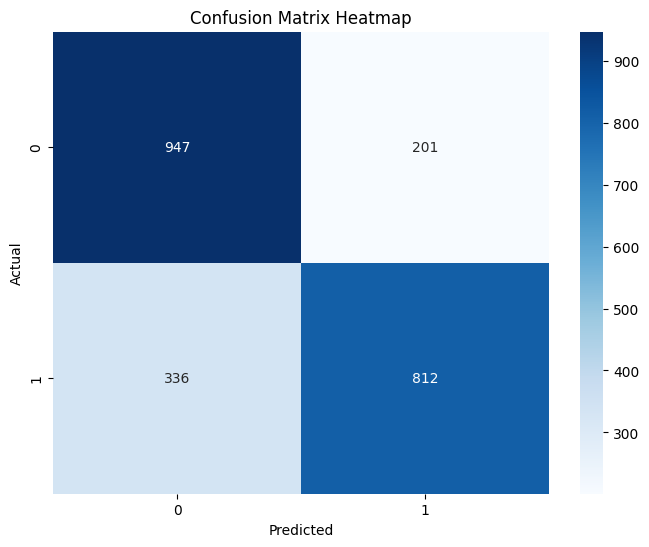

In [31]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_combined, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


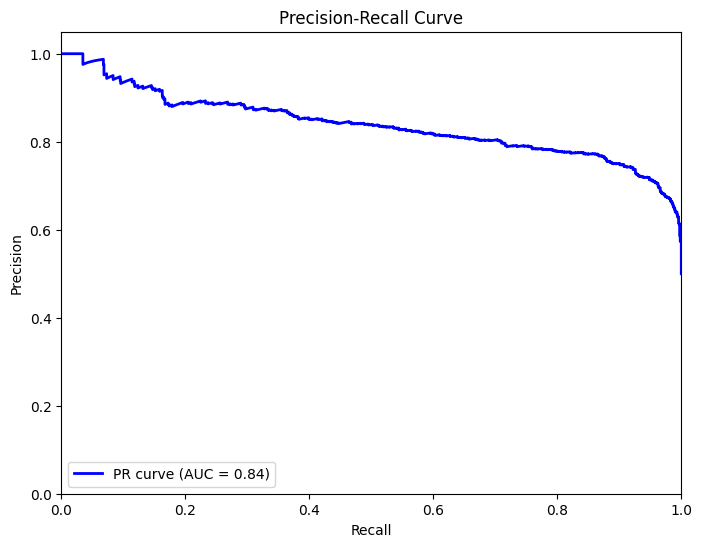

In [42]:
# Plot Precision-Recall curve
best_clf = grid_search.best_estimator_
y_scores = best_clf.decision_function(X_test_norm)
precision, recall, _ = precision_recall_curve(y_test_combined, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

AUC: 0.8678302820235769


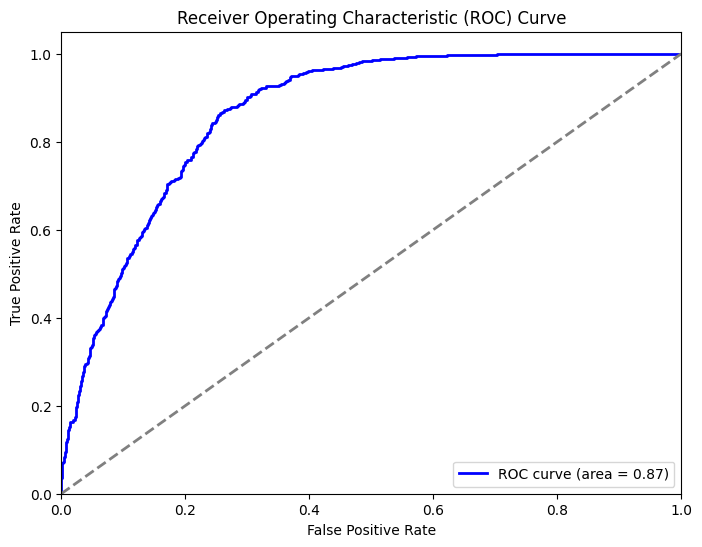

In [43]:
# Calculate ROC curve


fpr, tpr, thresholds = roc_curve(y_test_combined, y_scores)

# Calculate AUC
roc_auc = roc_auc_score(y_test_combined, y_scores)
print("AUC:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Shuffle the labels
y_train_shuffled = np.random.permutation(y_train_final)

# Train the model using the shuffled labels
grid_search.fit(X_train_norm, y_train_shuffled)

In [145]:
# Predict the response for the test dataset using the model trained on shuffled labels
y_pred_shuffled = grid_search.predict(X_test_norm)
y_scores_shuffled = grid_search.decision_function(X_test_norm)

In [146]:
# Evaluate the model trained on shuffled labels
print("Accuracy with Shuffled Labels:", accuracy_score(y_test_combined, y_pred_shuffled))
print("AUC with Shuffled Labels:", roc_auc_score(y_test_combined, y_scores_shuffled))

Accuracy with Shuffled Labels: 0.4838850174216028
AUC with Shuffled Labels: 0.46520004491981204


In [ ]:
# Shuffling the labels does not improve our model. 